# Waldo vs Not Waldo Classification

Thanks to __, we have a dataset of __ images of either Waldo or not Waldo of varying sizes and color. In this project, we will use various model architecture to classify these images as either Waldo or not Waldo.

https://medium.com/bitgrit-data-science-publication/building-an-image-classification-model-with-pytorch-from-scratch-f10452073212 

In [ ]:
%pip install -r requirements.txt

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from numpy import random
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from torchvision.io import read_image
from sklearn.model_selection import train_test_split

from PIL import Image

In [213]:
random.seed(10)
torch.manual_seed(20)
SIZE = 64
NOTWALDO = f'Hey-Waldo/{SIZE}/notwaldo'
WALDO = f'Hey-Waldo/{SIZE}/waldo'

### Preliminary Data Exploration

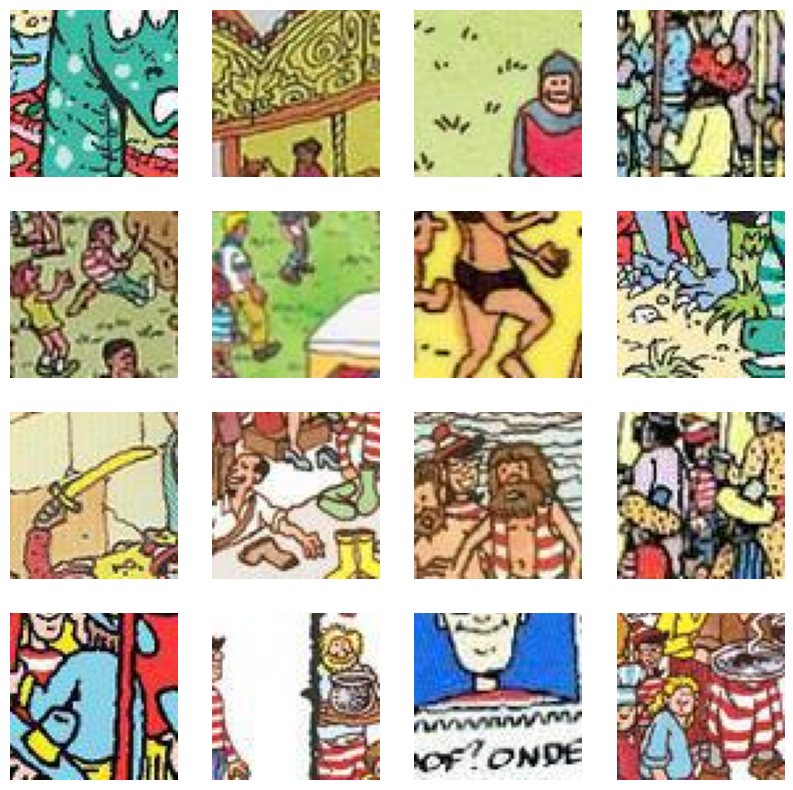

In [5]:
nrows, ncols = 4, 4

ig, ax = plt.subplots(nrows,ncols,figsize = (10,10))
ax = ax.flatten()

for i in range(nrows*ncols):
  if i < 8:
    pic = plt.imread(NOTWALDO + '/' + os.listdir(NOTWALDO)[i%8])
    ax[i].imshow(pic)
    ax[i].set_axis_off()
  else:
    pic = plt.imread(WALDO + '/' + os.listdir(WALDO)[i%8])
    ax[i].imshow(pic)
    ax[i].set_axis_off()
plt.show()

# Creating Dataset

Because there is an imbalance in the dataset, we will try 

In [6]:
# convert images to torch tensors 
# (PILImage images range [0, 1], transform to Tensors range [-1, 1].
rnd_idx = random.choice(range(len(os.listdir(NOTWALDO))), size=[50])
read_img = transforms.Compose([transforms.PILToTensor()])

notwaldo = []
waldo = []
img_labels = []

for i in rnd_idx:
    fname = os.listdir(NOTWALDO)[i]
    img_labels.append(['notwaldo/' + fname, 0])
    image = Image.open(NOTWALDO + '/' + fname)
    notwaldo.append(read_img(image))

for i in os.listdir(WALDO):
    img_labels.append(['waldo/' + i, 1])
    image = Image.open(WALDO + '/' + i)
    waldo.append(read_img(image))

In [7]:
df = pd.DataFrame(img_labels, columns=['fname', 'label'])

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

train_df.to_csv('img_labels_train.csv', index=False)
test_df.to_csv('img_labels_test.csv', index=False)

In [8]:
print( f'waldo images: {len(os.listdir(WALDO))}, not waldo images: {len(os.listdir(NOTWALDO))}')

waldo images: 39, not waldo images: 5337


In [25]:
class WaldoDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [202]:
transform = transforms.Compose( # composing several transforms together
    [transforms.ToPILImage(), # to tensor object
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # mean = 0.5, std = 0.5
     ])

batch_size = 4
num_workers = 2

trainset = WaldoDataset(annotations_file='img_labels_train.csv', img_dir=f'Hey-Waldo/{SIZE}', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

# load test data
testset = WaldoDataset(annotations_file='img_labels_test.csv', img_dir=f'Hey-Waldo/{SIZE}', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)


In [163]:
def imshow(img):
  ''' function to show image '''
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

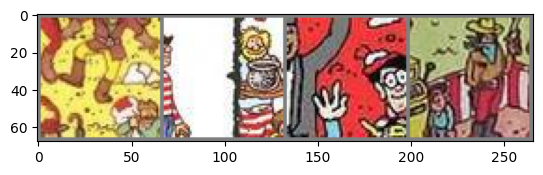

GroundTruth:  Not Waldo | Waldo | Waldo | Not Waldo |


In [196]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
classes = ['Not Waldo', 'Waldo']

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%s |' % classes[labels[j]] for j in range(4)))

# Using simple CNN architecture

In [217]:
class Net(nn.Module):
    ''' Models a simple Convolutional Neural Network'''
	
    def __init__(self):
        super(Net, self).__init__()
	# 3 input image channel, 6 output channels, 
	# 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
	# Max pooling over a (2, 2) window
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1 = nn.Linear(16 * 13 * 13, 120)# 5x5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 13 * 13)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2704, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


Finished Training


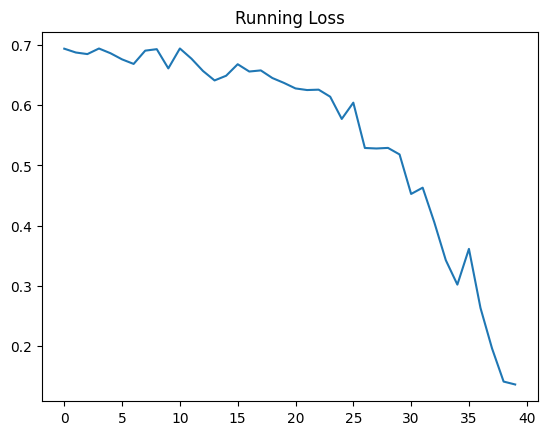

In [218]:
# start = torch.cuda.Event(enable_timing=True)
# end = torch.cuda.Event(enable_timing=True)

# start.record()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

losses = []
for epoch in range(45):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        
        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            # print('[%d, %d] loss: %.3f' %
            #       (epoch + 1, i + 1, running_loss / 10))
            losses.append(running_loss / 10)
            running_loss = 0.0

# # whatever you are timing goes here
# end.record()

# # Waits for everything to finish running
# torch.cuda.synchronize()
print('Finished Training')
plt.plot(losses)
plt.title('Running Loss')
plt.show()
# print(start.elapsed_time(end))  # milliseconds

# Test

In [219]:
# without any image augmentation

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on test images: 66 %


# Adding image augmentation

In [257]:
transform_aug = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(5),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4
num_workers = 2

trainset = WaldoDataset(annotations_file='img_labels_train.csv', img_dir=f'Hey-Waldo/{SIZE}', transform=transform_aug)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

# load test data
testset = WaldoDataset(annotations_file='img_labels_test.csv', img_dir=f'Hey-Waldo/{SIZE}', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

In [ ]:
# start = torch.cuda.Event(enable_timing=True)
# end = torch.cuda.Event(enable_timing=True)
# start.record()
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

losses = []
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        
        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            # print('[%d, %d] loss: %.3f' %
            #       (epoch + 1, i + 1, running_loss / 10))
            losses.append(running_loss / 10)
            running_loss = 0.0

# # whatever you are timing goes here
# end.record()

# # Waits for everything to finish running
# torch.cuda.synchronize()
print('Finished Training')
plt.plot(losses)
plt.title('Running Loss')
plt.show()
# print(start.elapsed_time(end))  # milliseconds

In [ ]:
# without any image augmentation

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))